### Add Conv1D convolution layer for temporal convolution
- A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret. This hybrid model is called a **CNN-LSTM**.
- A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, whereas it is not so important where the feature is located in the segment. 1D Convolutional Neural Networks work well for:
    - Analysis of a time series of sensor data.
    - Analysis of signal data over a fixed-length period, for example, an audio recording.
    - Natural Language Processing (NLP), although Recurrent Neural Networks which leverage Long Short Term Memory (LSTM) cells are more promising than CNN as they take into account the proximity of words to create trainable patterns.
- A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/ 

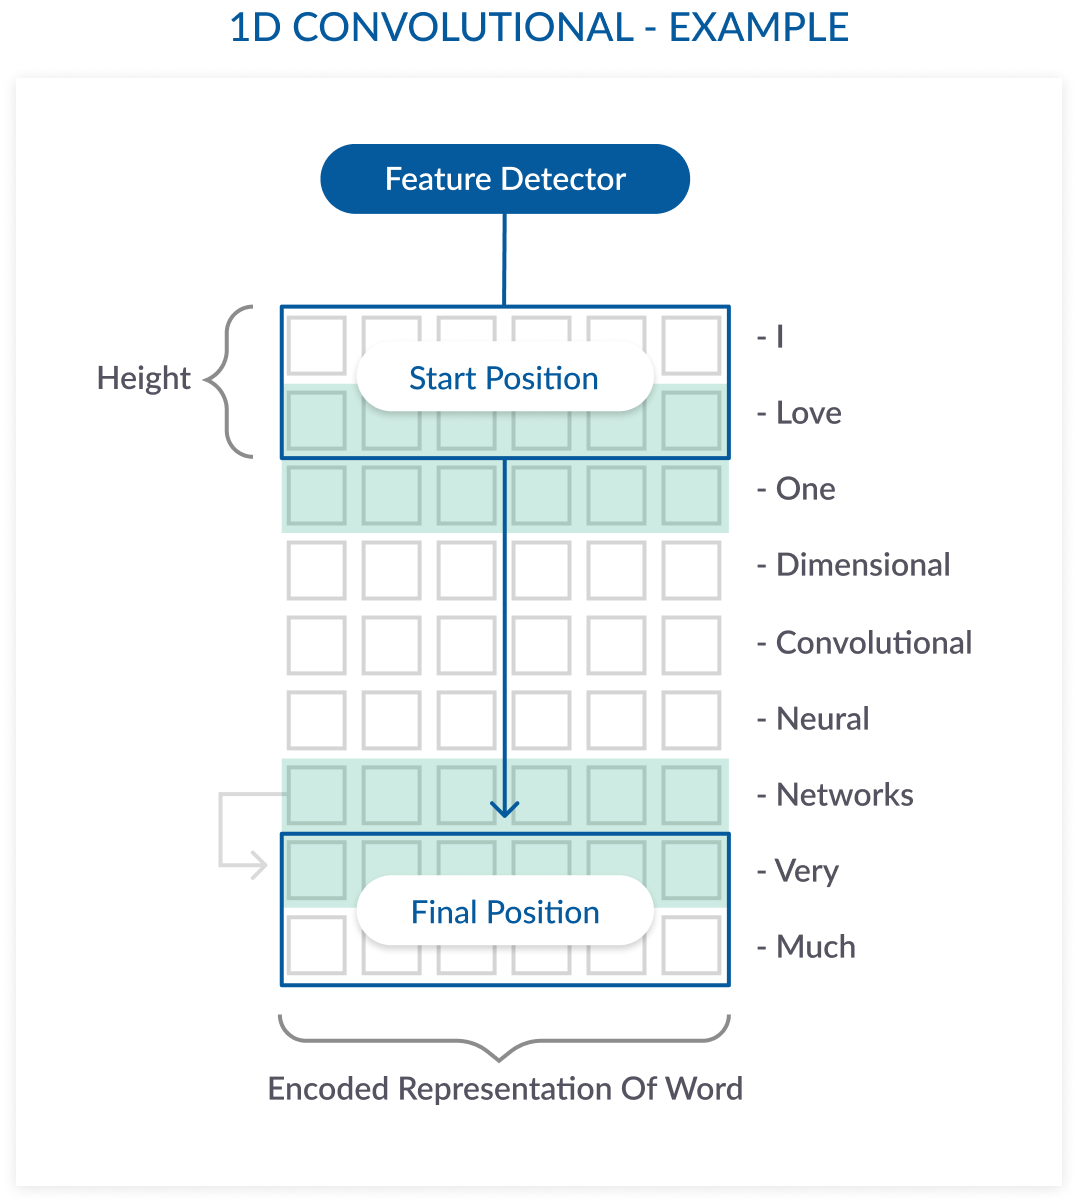

In [9]:
# Conv1D quick lesson
from IPython.display import Image
Image(filename='files/1D-convolutional-example_2x.png',width="400") 

#### Conv1D Parameters
**keras.layers.Conv1D**(filters, kernel_size, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
- filters: The number of reads or interpretations of the input sequence. It sets the number of output filters used in the convolution operation.
- kernel_size: The number of time steps included of each ‘read’ operation of the input sequence. It specifies the size of the convolutional window. 
- strides: The strides parameter is specifying the shift size of the convolution window
- padding: The padding parameter has three values: valid, causal or same. 
    - Valid: input will be non-zero padded, output will be smaller than the dimensions of the original image. 
    - Same: input will be zero padded, so the convolution output can be the same size as the input. 
    - Causal: output does not depend on the input

In [22]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
# use wget to download onlne data
import wget
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
file = wget.download(url)
file

100% [..............................................................................] 67921 / 67921

'daily-min-temperatures.csv'

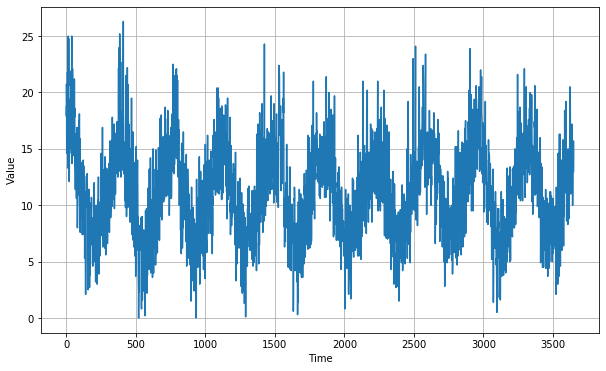

In [10]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)   # skip 1st row
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [11]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
# this block is trying to find the best lerning_rate

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 651ms/step - loss: 31.1571 - mae: 31.6550
Epoch 2/100
10/10 [==============================] - 5s 525ms/step - loss: 30.5778 - mae: 31.0756
Epoch 3/100
10/10 [==============================] - 6s 557ms/step - loss: 29.6825 - mae: 30.1801
Epoch 4/100
10/10 [==============================] - 3s 332ms/step - loss: 28.5613 - mae: 29.0586
Epoch 5/100
10/10 [==============================] - 8s 813ms/step - loss: 27.1974 - mae: 27.6945
Epoch 6/100
10/10 [==============================] - 5s 507ms/step - loss: 25.5017 - mae: 25.9986
Epoch 7/100
10/10 [==============================] - 6s 604ms/step - loss: 23.3464 - mae: 23.8429
Epoch 8/100
10/10 [==============================] - 6s 576ms/step - loss: 20.6148 - mae: 21.1108
Epoch 9/100
10/10 [==============================] - 13s 1s/step - loss: 17.3142 - mae: 17.8091
Epoch 10/100
10/10

[1e-08, 0.0001, 0, 60]

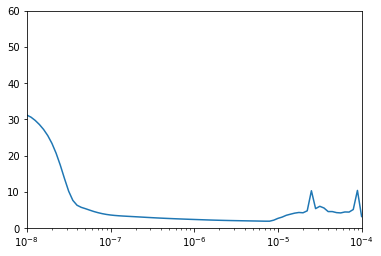

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 5s 208ms/step - loss: 9.9820 - mae: 10.4700
Epoch 2/150
25/25 [==============================] - 7s 292ms/step - loss: 2.5294 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 9s 350ms/step - loss: 1.9501 - mae: 2.4046
Epoch 4/150
25/25 [==============================] - 11s 432ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 12s 467ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 11s 430ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 12s 477ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 14s 567ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 15s 606ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 15s 609ms/step - loss: 1.7000 - mae: 2.1483
Epoch 11/150
25/25 [===========

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

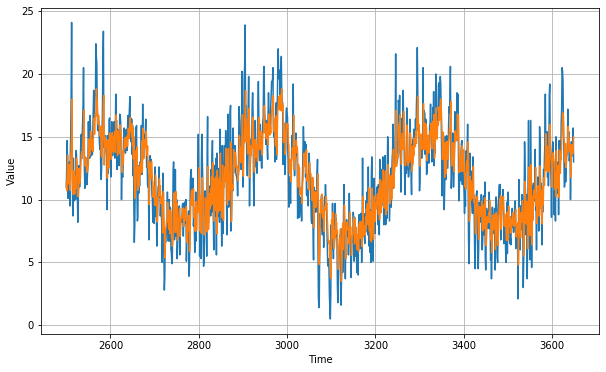

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796254

In [21]:
print(rnn_forecast)

[11.327806 10.704856 12.123924 ... 13.603828 13.795918 15.008247]
